# Matlab Kernel for Jupyter

## Overview

Let's see how matlab behaves inside Jupyter.
Perhaps this will make it easier to either compare GPML and scikit-learn's Gaussian Processes module, or just call GPML from Python with less overhead.


## Installation

### Install the kernel

First off, activate your favorite Python environment. I personally switched to Anaconda after avoiding it for a long time and sticking to `virtualenv`. It payed off immensely.

Then install the kernel as detailed in [its official instructions][1].

```Bash
pip install matlab_kernel
python -m matlab_kernel.install
```

Don't forget to set the `$MATLAB_EXECUTABLE` environment variable in your shell config.

### Launch the kernel

When first starting the notebook, this kernel will be a bit slower to load than Python or R kernels. The first cell will also have a bit of lag, but afterwards the latency should be gone.

Note that the kernel *usually* messes up and seemingly hangs if you're already running Matlab, at least on OSX.


### Install the GPML library

Follow the instructions from [the GPML documentation][2] and unpack the downloaded zip/tar in the same folder as this notebook.

[1]: https://pypi.python.org/pypi/matlab_kernel
[2]: http://www.gaussianprocess.org/gpml/code/matlab/doc/

In [3]:
1 + 1

ans =

     2


In [4]:
disp('I am matlab')

I am matlab


In [4]:
%%python

print("Hello, I am python")

Hello, I am python


In [14]:
%%javascript

// alert("JS, if you're masochistic like that.")

<IPython.core.display.Javascript object>

# Getting Serious: GPML

In [5]:
addpath(genpath('./'))

% This should print a usage string.
gp

Usage: [nlZ dnlZ          ] = gp(hyp, inf, mean, cov, lik, x, y);
   or: [ymu ys2 fmu fs2   ] = gp(hyp, inf, mean, cov, lik, x, y, xs);
   or: [ymu ys2 fmu fs2 lp] = gp(hyp, inf, mean, cov, lik, x, y, xs, ys);


In [6]:
% Train
meanfunc = @meanConst;
hyp.mean = 0;
covfunc = @covLIN;
hyp.cov = [];
likfunc = @likErf;

% hyp = minimize(hyp, @gp, -40, @infEP, meanfunc, covfunc, likfunc, x, y);

In [9]:
% Official example for GPML regression

% Note: for defining the prior mean and covariance, as well as
% the likelihood function, we use these GPML library-specific
% constructs, and not just e.g. anonymous functions. See the
% documentation for more info.

% Composite mean function: linear + some constant.
meanfunc = {@meanSum, {@meanLinear, @meanConst}};

% The 'hyp' (hypothesis) struct is used for passing concrete values
% to the mean, cov, and likelihood functions.
hyp.mean = [0.5; 1];

% This is the function that the example uses to model covariance
% between two points: The Matern Covariance. It's a pretty nasty
% function of the distance between two points, parameterized by
% two numers: rho and v (small nu).
% The '3' below signifies the smoothness of the Gaussian process.
% From docs: covMaterniso  - Matern covariance function with nu=1/2, 3/2 or 5/2
% Could also use e.g. linear or constant covariance, or other funky
% functions.
covfunc = {@covMaterniso, 3};
ell = 1/4;
sf = 1;

% length-scale and standard deviation of signal.
hyp.cov = log([ell; sf]);
likfunc = @likGauss;
% Standard deviation of noise.
sn = 0.1;
hyp.lik = log(sn);

n = 20;
x = gpml_randn(0.3, n, 1);
% This is just the covariance matrix for our generated numbers.
K = feval(covfunc{:}, hyp.cov, x);
mu = feval(meanfunc{:}, hyp.mean, x);

% Wikipedia has a concise explanation: 
% The Cholesky decomposition or Cholesky factorization is a
% decomposition of a Hermitian, positive-definite matrix into
% the product of a lower triangular matrix and its conjugate
% transpose, which is useful e.g. for efficient numerical
% solutions and Monte Carlo simulations. 
% I still have no idea why the fuck they're doing this.
y = chol(K)' * gpml_randn(0.15, n, 1) + mu + exp(hyp.lik) * gpml_randn(0.2, n, 1);

Note: A real and symmetric matrix is simply a special case of a Hermitian matrix. Our (real) covariance matrix is real and symmetric, so we can apply Cholesky decomposition to it.

#### The Matern Covariance Function

For $\nu = 1$ we have the following covariance function:

$$
C_{\nu = 1}(d) = \sigma^2 \frac{1}{\Gamma(1)}\left( \sqrt{2}\frac{d}{\rho} \right) K_1 \left( \sqrt{2}\frac{2}{\rho} \right)
$$

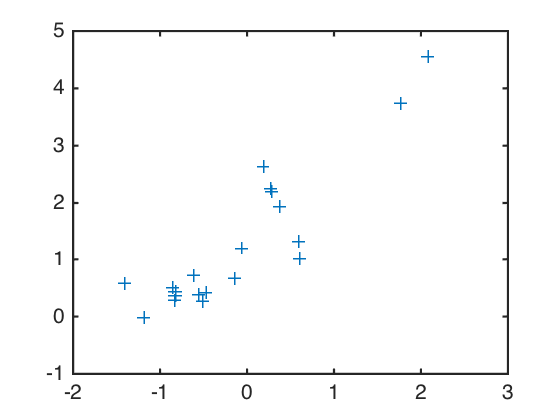

In [8]:
plot(x, y, '+')

In [10]:
% Let's ask the model to compute the (joint) negative log
% probability (density) nlml (also called marginal likelihood
% or evidence) and to generalize from the training data to
% other (test) inputs z:

nlml = gp(hyp, @infExact, meanfunc, covfunc, likfunc, x, y)

nlml =

   11.9706


In [11]:
z = linspace(-1.9, 1.9, 101)';
% Train from x and y, and predict for z.
% Returns means and variances.
[m s2] = gp(hyp, @infExact, meanfunc, covfunc, likfunc, x, y, z);

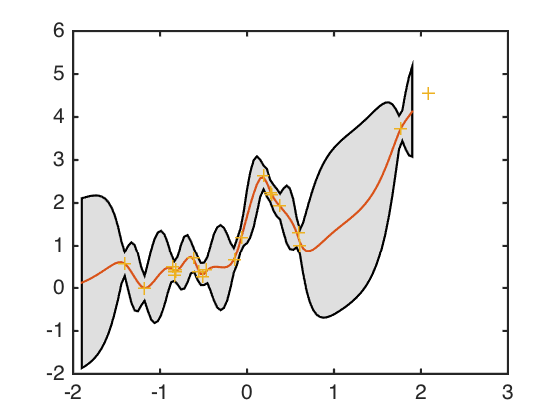

In [13]:
% Use means and variances of predictions to compute 95% confidence
% interval around predicted means.
f = [m+2*sqrt(s2); flipdim(m-2*sqrt(s2),1)]; 
fill([z; flipdim(z,1)], f, [7 7 7]/8)
hold on; plot(z, m); plot(x, y, '+')

TODO(andrei): Finish second part of tutorial, where we also pretend we don't know any of the hyperparameters, and want to learn them.